<a href="https://colab.research.google.com/github/faithrts/Science_Explainers/blob/main/embeddings_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
### importing libraries

# basic libraries
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

import os
import re
import codecs

import nltk
from nltk import word_tokenize
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

import string

from sklearn.manifold import TSNE

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Importing datasets

In [2]:
### cloning git repos

!git clone https://github.com/faithrts/Science_Explainers
#!git clone https://github.com/dhmit/gender_novels
#!git clone https://github.com/faithrts/Short_Fiction

Cloning into 'Science_Explainers'...
remote: Enumerating objects: 2007, done.
remote: Counting objects: 100% (216/216), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 2007 (delta 109), reused 123 (delta 42), pack-reused 1791
Receiving objects: 100% (2007/2007), 100.64 MiB | 16.41 MiB/s, done.
Resolving deltas: 100% (897/897), done.
Filtering content: 100% (17/17), 855.28 MiB | 36.07 MiB/s, done.
Encountered 2 file(s) that should have been pointers, but weren't:
	dataset/article_urls.csv
	dataset/science_explainers_dataset.csv


In [3]:
### saving datasets into dataframes

explainer_df = pd.read_csv('Science_Explainers/dataset/science_explainers_dataset.csv')
fiction_df = pd.read_csv('short_fiction_dataset.csv')
news_df = pd.read_csv('news_dataset.csv')
sci_paper_df = pd.read_csv('scientific_papers_dataset.csv')

In [4]:
### unzipping txt files (will later add full text + text count to dfs after helper functions)

!unzip Science_Explainers/dataset/science_txt_files.zip
!unzip fiction_txt_files.zip

Archive:  Science_Explainers/dataset/science_txt_files.zip
   creating: science_txt_files/
   creating: science_txt_files/CBC/
  inflating: science_txt_files/CBC/BatsGrowlLikeDeathMetalSingers.txt  
  inflating: science_txt_files/CBC/MarkingsOnTheLegAndButt.txt  
  inflating: science_txt_files/CBC/StudyRevealsSeriousCancerResearchGaps.txt  
  inflating: science_txt_files/CBC/WhosToBlameForContaminatedShellfish.txt  
  inflating: science_txt_files/CBC/RiseInExtremeWildfiresLinkedDirectly.txt  
  inflating: science_txt_files/CBC/HowDoPolarBearsEatWhen.txt  
  inflating: science_txt_files/CBC/TimeInSpaceIsBadFor.txt  
  inflating: science_txt_files/CBC/NewStudySupportsAlternativesToRadiation.txt  
  inflating: science_txt_files/CBC/GeneeditedPigKidneyKeepsMonkeyAlive.txt  
  inflating: science_txt_files/CBC/FossilsPaintThePictureOfGorillasized.txt  
  inflating: science_txt_files/CBC/ThisBcValleyHasBecomeA.txt  
  inflating: science_txt_files/CBC/AlbertasOilsandsPumpOutMorePollutants.txt 

## Helper functions

### Data processing

In [5]:
### turns all column names to upper case
def uppercase_columns(df):
  columns = df.columns
  new_columns = [column.upper() for column in columns]
  df.columns = new_columns

In [6]:
### counts the word count of the text and adds it as a column
def count_text_length(df):
  df['LENGTH'] = ''

  for index, row in df.iterrows():
    text = row['TEXT']
    text_length = len(text)
    df.at[index, 'LENGTH'] = text_length

In [7]:
### where "path" is, for example, "science_txt_files/""
def load_text_content(df, path):

  # adds new column to the dataframe
  df['TEXT'] = ''

  for index, row in df.iterrows():
    cur_filename = row['FILENAME']

    # renaming files with weird accent characters in their names
    if 'í' in cur_filename and os.path.isfile(path + cur_filename.replace('í', 'í')):
      os.rename(path + cur_filename.replace('í', 'í'), path + cur_filename)
    if 'é' in cur_filename and os.path.isfile(path + cur_filename.replace('é', 'é')):
      os.rename(path + cur_filename.replace('é', 'é'), path + cur_filename)

    cur_article = codecs.open(path + cur_filename, 'r', encoding = 'utf8').read()

    # saving the text in the dataframe
    df.at[index, 'TEXT'] = cur_article

In [8]:
### custom pre-processor to eliminte numbers and instances of "_", "\", and "—"
def my_preprocessor(text):
    text = text.lower()
    text = re.sub('([0-9—_\\\\])', '', text)
    return text

In [9]:
### makes all the column names UPPERCASE
def col_names_to_uppercase(df):
  new_columns = [name.upper() for name in df.columns]
  df.columns = new_columns

  return df

In [10]:
def refine_df_columns(list_of_titles, df):

  # the new df with only the columns to keep
  df_copy = df[list_of_titles]

  return df_copy

# Loading content

In [68]:
### adding the text of each article as a column in the dataframe

# science explainers
load_text_content(explainer_df, 'science_txt_files/')
# count_text_length(explainer_df)

# fiction
load_text_content(fiction_df, 'fiction_txt_files/')
# count_text_length(fiction_df)

# news articles
# count_text_length(news_df)

# scientific papers
# count_text_length(sci_paper_df)

# Tokenizing text

In [65]:
my_stopwords = ['www,', 'arxiv', 'pubmed']

In [81]:
def tokenize_text(list_of_dfs):

  # initializing the tokenizer
  tokenizer = TreebankWordTokenizer()

  for df in list_of_dfs:
    df['TOKENS'] = ''

    for index, row in df.iterrows():
      text = row['TEXT']

      # tokenizes the text, removing punctuation and extraneous characters
      # tokens = gensim.utils.simple_preprocess(text)
      from nltk import word_tokenize
      from nltk.corpus import stopwords
      import string

      # removes LaTeX tags (words that start with @ or \)
      tokens = re.sub('(@|\\\)\S*', '', text)

      # stop = set(stopwords.words('english') + list(string.punctuation) + my_stopwords)
      remove_words = set(list(re.sub('', '', string.punctuation)) + my_stopwords)
      # strip removes the quotes around words
      tokens = [i.strip('‘"’\'') for i in tokenizer.tokenize(text.lower()) if i not in remove_words]

      df.at[index, 'TOKENS'] = tokens

In [82]:
tokenize_text([explainer_df, fiction_df, news_df, sci_paper_df])

# Creating Doc2Vec model

In [ ]:
# Set file names for train and test data
test_data_dir = os.path.join(gensim.__path__[0], 'test', 'test_data')
lee_train_file = os.path.join(test_data_dir, 'lee_background.cor')
lee_test_file = os.path.join(test_data_dir, 'lee.cor')

In [ ]:
import smart_open

def read_corpus(fname, tokens_only=False):
    with smart_open.open(fname, encoding="iso-8859-1") as f:
        for i, line in enumerate(f):
            tokens = gensim.utils.simple_preprocess(line)
            if tokens_only:
                yield tokens
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

train_corpus = list(read_corpus(lee_train_file))
test_corpus = list(read_corpus(lee_test_file, tokens_only=True))

In [56]:
def make_list_of_TaggedDocuments(list_of_dfs):

  counter = 0
  list_of_TaggedDocuments = []

  for df in list_of_dfs:
    for index, row in df.iterrows():
      text = row['TEXT']
      # tokenizes the text, removing punctuation and extraneous characters
      tokens = gensim.utils.simple_preprocess(text)
      tag = str(counter)

      cur_TaggedDocument = TaggedDocument(words = tokens, tags = [tag])
      list_of_TaggedDocuments.append(cur_TaggedDocument)

      # increment the counter
      counter += 1

  return list_of_TaggedDocuments

In [57]:
train_corpus = make_list_of_TaggedDocuments([explainer_df, fiction_df, news_df, sci_paper_df])

In [58]:
# instantiate Doc2Vec model
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=5, epochs=40)

# builds a vocabulary
model.build_vocab(train_corpus)

'''
Essentially, the vocabulary is a list (accessible via model.wv.index_to_key)
of all of the unique words extracted from the training corpus. Additional
attributes for each word are available using the model.wv.get_vecattr('penalty', 'count) method,
for example, to see how many times "penalty" appeared in the training corpus:
'''

'\nEssentially, the vocabulary is a list (accessible via model.wv.index_to_key)\nof all of the unique words extracted from the training corpus. Additional\nattributes for each word are available using the model.wv.get_vecattr(\'penalty\', \'count) method,\nfor example, to see how many times "penalty" appeared in the training corpus:\n'

In [59]:
# trains the model
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
'''
Now, we can use the trained model to infer a vector for any piece of text by
passing a list of words to the model.infer_vector function. This vector can
then be compared with other vectors via cosine similarity.
'''

vector = model.infer_vector(['only', 'you', 'can', 'prevent', 'forest', 'fires'])
print(vector)

[-0.4454815   0.02155577 -0.3962693  -0.0586681  -0.3872609   0.20494844
 -0.29623136  0.46718425 -0.49960473  0.2576679   0.46012214 -0.07356273
  0.4155775   0.14196403 -0.26919028 -0.18272938  0.11223676  0.24739541
 -0.12714987 -0.10418699  0.3541627   0.1600769  -0.1170135   0.14598358
  0.5204808   0.38873643 -0.45567313  0.1708439  -0.59770566 -0.04646982
  0.601749    0.47190303 -0.3561889   0.26525694 -0.11369828  0.22323912
  0.07071856 -0.25384712  0.21417592  0.03453937 -0.04144079  0.10075849
 -0.3248599  -0.6326788  -0.24397753  0.20951131  0.4338821   0.12977192
 -0.00859862  0.41084015]


In [60]:
# saves model

model.save('ose_doc2vec.model')

# Loading Doc2Vec model

In [11]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# loads model
model = Doc2Vec.load('ose_doc2vec.model')

In [ ]:
tokens_test = gensim.utils.simple_preprocess(sci_paper_df['TEXT'].iloc[2])

# Getting document vectors

In [12]:
def get_doc_vectors(list_of_dfs, model):
  doc_vectors = []

  for df in list_of_dfs:
    for index, row in df.iterrows():
      text = row['TEXT']

      tokens = gensim.utils.simple_preprocess(text)
      vector = model.infer_vector(tokens).tolist()

      doc_vectors.append(vector)

  # turning overarching list into numpy array
  doc_vectors = np.array(doc_vectors)

  return doc_vectors

In [13]:
def save_doc_vectors(doc_vectors):
  with open('doc_vectors.txt', 'w') as f:
    f.write(str(doc_vectors.tolist()))

In [14]:
def import_doc_vectors(filename = 'doc_vectors.txt'):
  with open(filename, 'r') as f:
    doc_vectors = f.read()

  # turning string list to list
  doc_vectors = eval(doc_vectors)

  # turning list to np array
  doc_vectors = np.array(doc_vectors)

  return doc_vectors

In [ ]:
# doc_vectors = get_doc_vectors([explainer_df, fiction_df, news_df, sci_paper_df], model)

doc_vectors = import_doc_vectors()

# Plot flattened embeddings

In [15]:
def make_plot_helper_df(doc_vectors):

  # the names of each text (explainer title, short fiction title, news title scientific paper title)
  doc_titles = explainer_df['FILENAME'].tolist() + fiction_df['FILENAME'].tolist() + news_df['ID'].tolist() + sci_paper_df['ID'].tolist()

  tsne = TSNE(n_components = 2)
  X_tsne = tsne.fit_transform(doc_vectors)

  plot_helper_df = pd.DataFrame(X_tsne, index = doc_titles, columns = ['x', 'y'])

  source_list = []
  for source in ['explainer', 'fiction', 'news', 'sci_paper']:
    source_list += [source] * len(eval(source + '_df'))

  plot_helper_df['SOURCE'] = source_list

  return plot_helper_df

In [29]:
def plot_doc_embeddings(plot_helper_df, annotate = '', add_top2 = False, add_bottom2 = False):
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)

  fig.set_size_inches(10.5, 10.5)

  explainer_count = len(explainer_df)
  fiction_count = len(fiction_df)
  news_count = len(news_df)
  sci_paper_count = len(sci_paper_df)

  # short fiction
  ax.scatter(plot_helper_df['x'][explainer_count:explainer_count + fiction_count], plot_helper_df['y'][explainer_count:explainer_count + fiction_count], c = 'r', label = 'Short fiction')

  # news reports
  ax.scatter(plot_helper_df['x'][explainer_count + fiction_count:explainer_count + fiction_count + news_count], plot_helper_df['y'][explainer_count + fiction_count:explainer_count + fiction_count + news_count], c = 'b', label = 'News articles')

  # scientific papers
  ax.scatter(plot_helper_df['x'][explainer_count + fiction_count + news_count:-1], plot_helper_df['y'][explainer_count + fiction_count + news_count:-1], c = 'm', label = 'Scientific papers')

  # science explainers
  ax.scatter(plot_helper_df['x'][0:explainer_count], plot_helper_df['y'][0:explainer_count], c = 'g', label = 'Science explainers')

  '''
    sources = ['explainer', 'fiction', 'news', 'sci_paper']
    colours = ['green', 'red', 'blue', 'magenta']

    for i in range(4):
      source = sources[i]
      colour = colours[i]

      points = annotate_points(plot_helper_df, source)
      for point in points:
        annotation = plt.text(*point)
        annotation.set_bbox(dict(facecolor = colour, alpha = 0.5, edgecolor = colour))
  '''

  if annotate != '':
    index = ['explainer', 'fiction', 'news', 'sci_paper'].index(annotate)
    colour = ['green', 'red', 'blue', 'magenta'][index]

    points = annotate_points(plot_helper_df, annotate, add_top2, add_bottom2)

    for point in points:
      annotation = plt.text(*point)
      annotation.set_bbox(dict(facecolor = colour, alpha = 0.8, edgecolor = colour))

  ax.legend(loc = 'lower left')
  plt.title('Flattened visualization of document embeddings')

In [94]:
def annotate_points(plot_helper_df, source, add_top2 = False, add_bottom2 = False):

  points_df = plot_helper_df.loc[plot_helper_df['SOURCE'] == source]
  locations = []
  point_annotations = []

  if source == 'sci_paper':
    points_l_df = points_df.loc[points_df['x'] <= 0]
    points_df = points_df.loc[points_df['x'] > 0]

    top_l = points_l_df['y'].idxmax()
    # bottom_l = points_l_df['y'].idxmin()

    left_l = points_l_df['x'].idxmin()
    right_l = points_l_df['x'].idxmax()

    ver_middle_l = abs(points_l_df['y'] - points_l_df['y'].mean()).idxmin()
    hor_middle_l = abs(points_l_df['x'] - points_l_df['x'].mean()).idxmin()

    ver_middle_r = abs(points_df['y'] - points_df['y'].mean()).idxmin()
    hor_middle_r = abs(points_df['x'] - points_df['x'].mean()).idxmin()

    locations += [top_l, left_l, right_l, ver_middle_l, hor_middle_l, ver_middle_r, hor_middle_r]

  top = points_df['y'].idxmax()
  top2 = points_df['y'].loc[~points_df.index.isin([top])].idxmax()

  bottom = points_df['y'].idxmin()
  bottom2 = points_df['y'].loc[~points_df.index.isin([bottom])].idxmin()

  left = points_df['x'].idxmin()
  right = points_df['x'].idxmax()

  locations += [top, bottom, left, right]

  if add_top2:
    locations.append(top2)
  if add_bottom2:
    locations.append(bottom2)

  for location in locations:
    cur_point = (plot_helper_df['x'].loc[location], plot_helper_df['y'].loc[location], location)
    point_annotations.append(cur_point)

  print(locations)

  return point_annotations

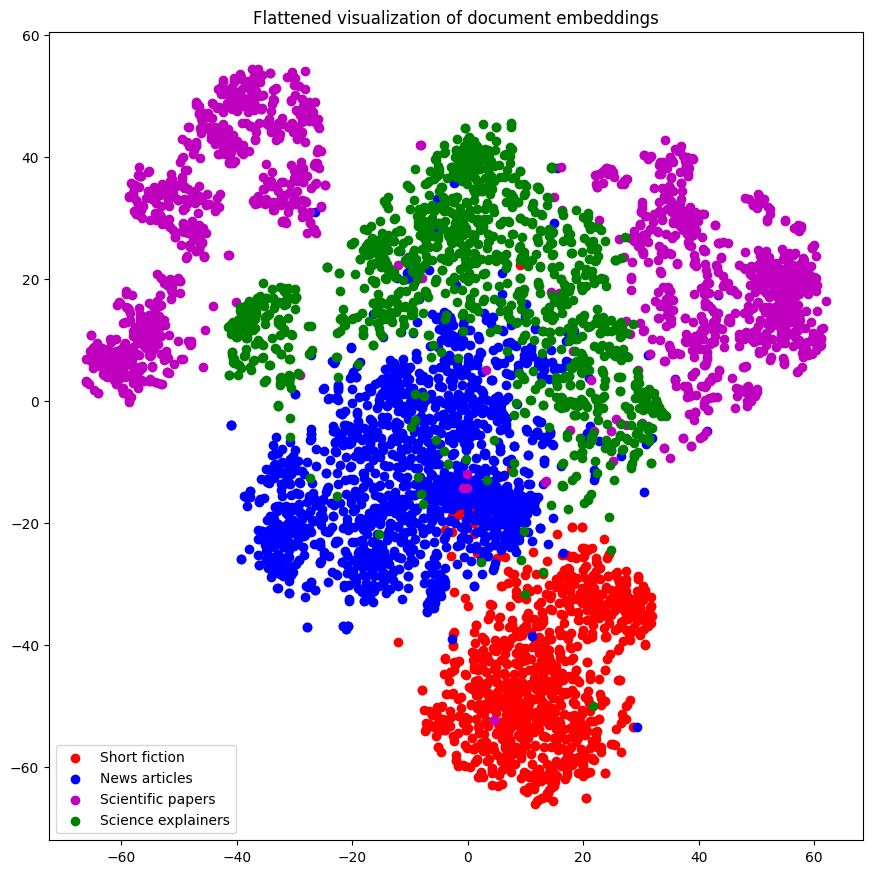

In [18]:
plot_helper_df = make_plot_helper_df(doc_vectors)
plot_doc_embeddings(plot_helper_df)

['REUTERS/LocksOfHairComposeASymphony.txt', 'GLOBE_AND_MAIL/HowFrenchImmersionInadvertentlyCreatedClass.txt', 'NPR/PeopleAreFreakingOutOverA.txt', 'CNN/HowToExerciseFromTheComfort.txt', 'ATLANTIC/ForTheLichens.txt']


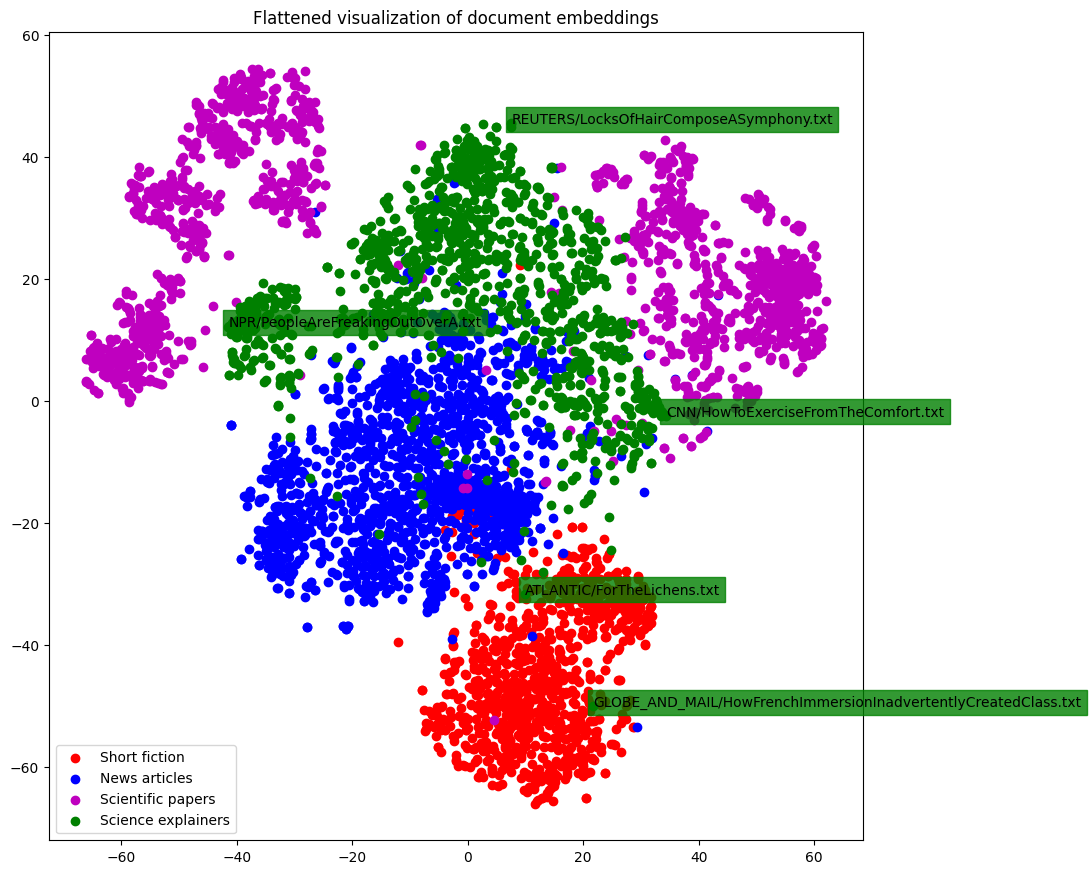

In [95]:
plot_doc_embeddings(plot_helper_df, annotate = 'explainer', add_bottom2 = True)

['TIN_HOUSE/RegardingLichen.txt', 'THE_SUN/TheNaturalOrderOfHebrewSchool.txt', 'PARIS_REVIEW/WhyVisitAmerica.txt', 'LIT_HUB/AHouseIsABody.txt', 'ELECTRIC/PoetryFlashFictionAndGraphicNarrative.txt']


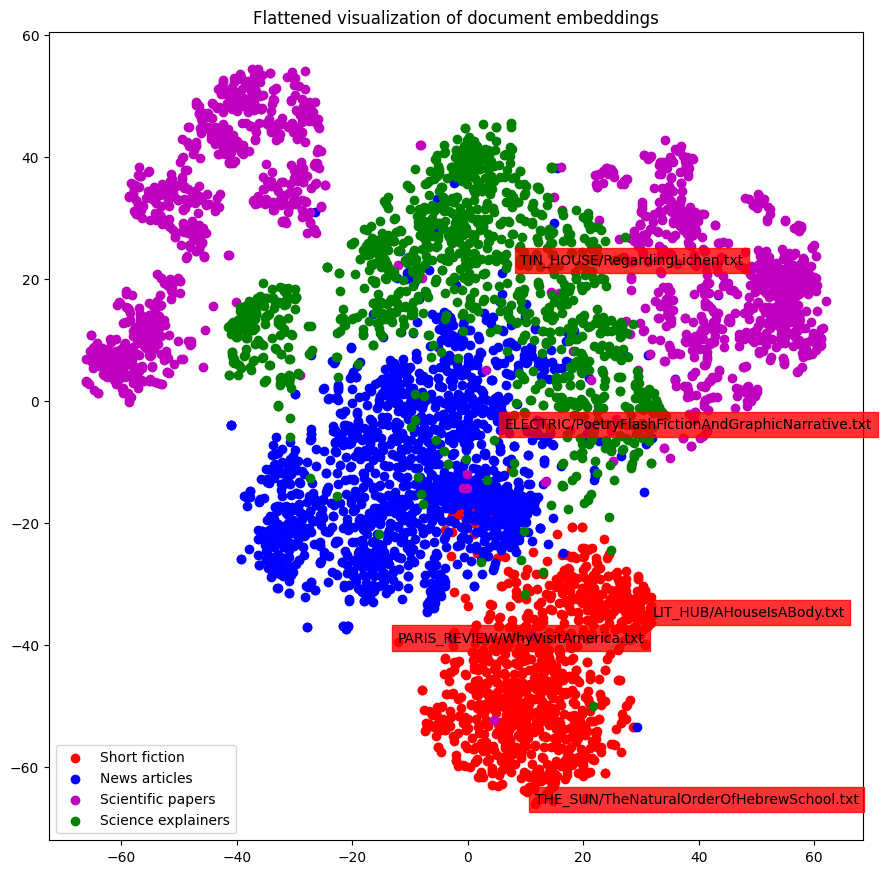

In [96]:
plot_doc_embeddings(plot_helper_df, annotate = 'fiction', add_top2 = True)

['fafbb5cf-f093-3ede-bca7-f8cf2dc79419', '1921100d-f5e1-4f96-bd1d-f75f3d78d196', '9ba8b1ec-a9fb-39cf-bb6f-f8d061bbac53', '32fd6c1d-e6c4-4f6e-b887-effc4244459a', '6bcf7890-3a6d-3ff6-b7f1-a0f3dff444f5']


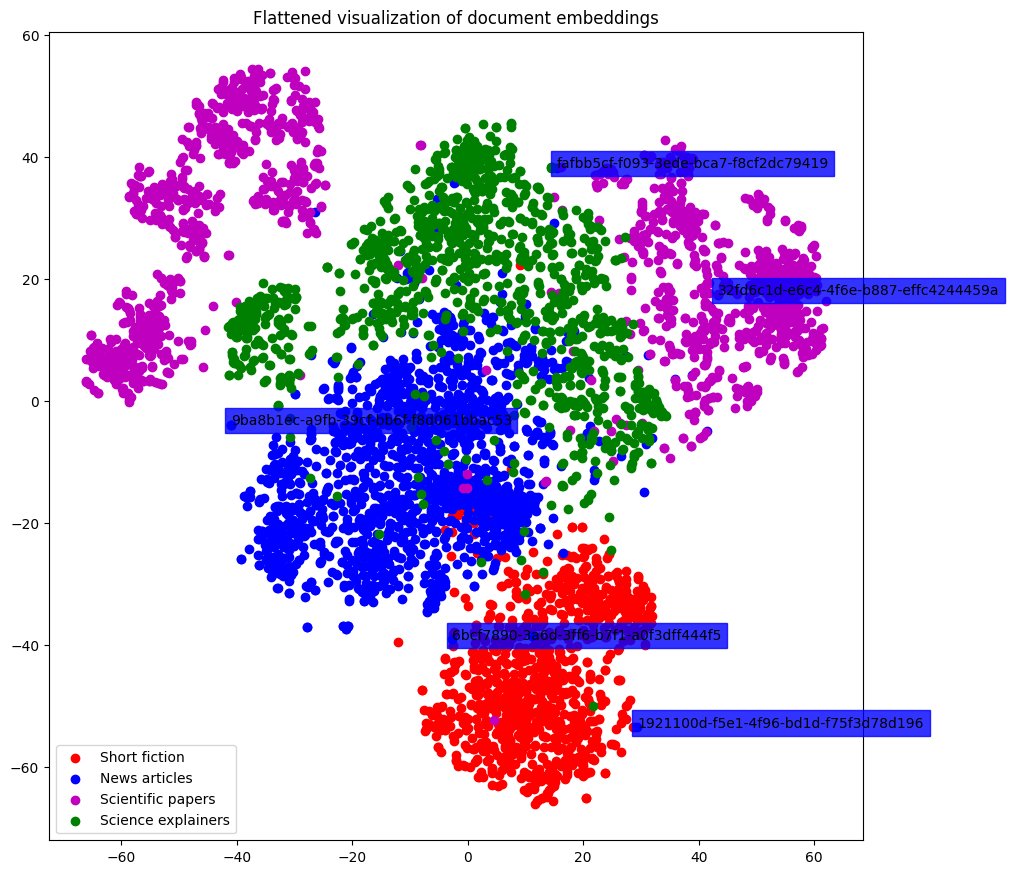

In [97]:
plot_doc_embeddings(plot_helper_df, annotate = 'news', add_bottom2 = True)

['PUBMED_335', 'ARXIV_174', 'PUBMED_75', 'ARXIV_467', 'ARXIV_746', 'PUBMED_530', 'PUBMED_367', 'PUBMED_361', 'ARXIV_179', 'PUBMED_64', 'PUBMED_433']


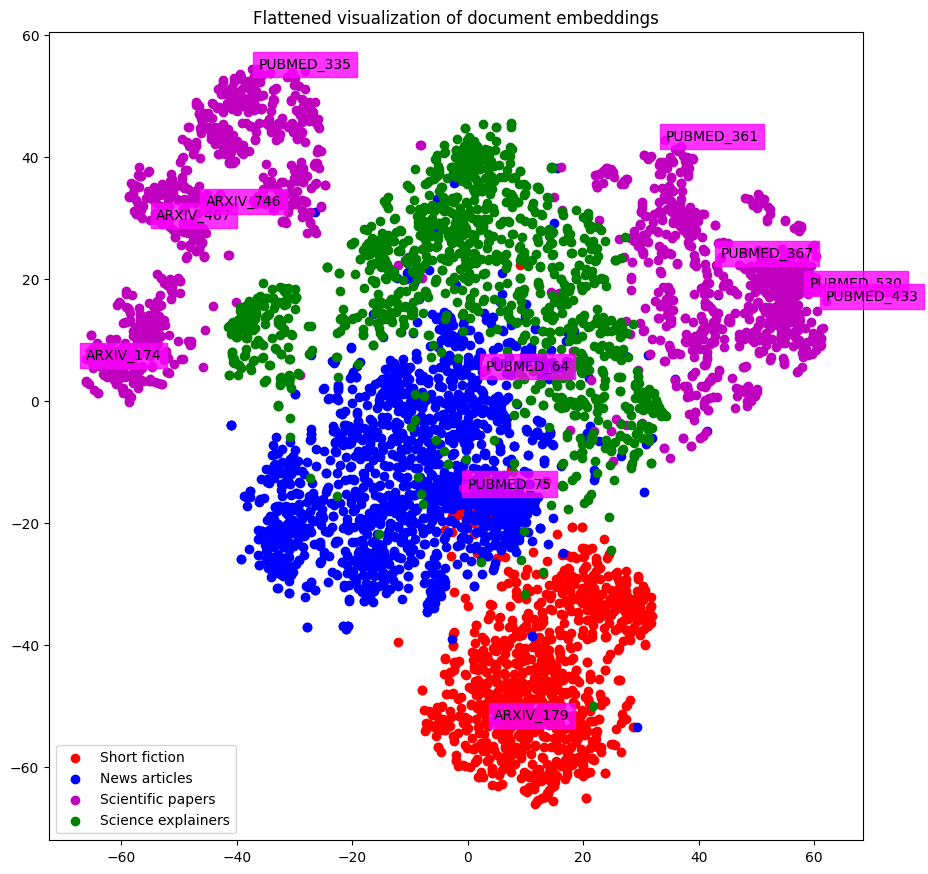

In [98]:
plot_doc_embeddings(plot_helper_df, annotate = 'sci_paper')

In [68]:
save_doc_vectors(doc_vectors)

In [62]:
index_list_l = plot_helper_df.loc[plot_helper_df['SOURCE'] == 'sci_paper'].loc[plot_helper_df['x'] < 0].index.values.tolist()
pubmed_count_l = ['PUBMED' in string for string in index_list_l]
len_l = len(pubmed_count_l)
print(f'Of the {len_l} datapoints in the left half, {pubmed_count_l.count(True)} are from PubMed')


Of the 769 datapoints on the left half, 21 are from Pubmed


In [63]:
index_list_r = plot_helper_df.loc[plot_helper_df['SOURCE'] == 'sci_paper'].loc[plot_helper_df['x'] >= 0].index.values.tolist()
pubmed_count_r = ['PUBMED' in string for string in index_list_r]
len_r = len(pubmed_count_r)
print(f'Of the {len_r} datapoints in the right half, {pubmed_count_r.count(True)} are from PubMed')

Of the 731 datapoints in the left half, 729 are from Pubmed


# Calculate token uniqueness ratio

In [86]:
def calculate_token_uniqueness_ratio(df):
  df['UNIQUE TOKENS'] = ''
  df['TOTAL TOKENS'] = ''
  df['RATIO'] = ''

  for index, row in df.iterrows():
    cur_tokens = row['TOKENS']

    cur_unique = len(set(cur_tokens))
    cur_total = len(cur_tokens)

    df.at[index, 'UNIQUE TOKENS'] = cur_unique
    df.at[index, 'TOTAL TOKENS'] = cur_total
    df.at[index, 'RATIO'] = cur_unique/cur_total

In [141]:
dfs = [explainer_df, fiction_df, news_df, sci_paper_df]
genres = ['Science explainers', 'Short fiction', 'News articles', 'Scientific papers']

print('Mean vocabulary richness (ratio of unique words to total words) per text per genre')

for i in range(len(dfs)):
  cur_df = dfs[i]
  calculate_token_uniqueness_ratio(cur_df)
  avg_rat = cur_df['RATIO'].mean()

  print(f'\t{genres[i]}: {round(avg_rat, 2)}')

Mean vocabulary richness (ratio of unique words to total words) per text per genre
	Science explainers: 0.48
	Short fiction: 0.4
	News articles: 0.54
	Scientific papers: 0.28


In [142]:
dfs = [explainer_df, fiction_df, news_df, sci_paper_df]
genres = ['Science explainers', 'Short fiction', 'News articles', 'Scientific papers']

print('Total vocabulary richness (ratio of unique words to total words) per genre')

for i in range(len(dfs)):
  cur_df = dfs[i]
  all_tokens = cur_df['TOKENS'].sum()
  all_tokens_count = len(all_tokens)
  all_unique_tokens_count = len(set(all_tokens))

  ratio = all_unique_tokens_count / all_tokens_count

  print(f'\t{genres[i]}: {round(ratio, 2)}')

Total vocabulary richness (ratio of unique words to total words) per genre
	Science explainers: 0.05
	Short fiction: 0.03
	News articles: 0.04
	Scientific papers: 0.02


In [137]:
len(explainer_df['TOKENS'].sum())

1253330

In [88]:
explainer_df

,FILENAME,TITLE,SOURCE,DATE PUBLISHED,URL,TOKENS,TEXT,UNIQUE TOKENS,TOTAL TOKENS,RATIO
0,ATLANTIC/15DegreesWasNeverTheEnd.txt,1.5 Degrees Was Never the End of the World,ATLANTIC,2023-02-01,https://www.theatlantic.com/science/archive/20...,"[the, most, famous, climate, goal, is, woefull...",The most famous climate goal is woefully misun...,610,1287,0.47397
1,ATLANTIC/ABasicPremiseOfAnimalConservation.txt,A Basic Premise of Animal Conservation Looks S...,ATLANTIC,2023-02-22,https://www.theatlantic.com/science/archive/20...,"[are, we, trying, to, save, animals, in, the, ...",Are we trying to save animals in the wrong pla...,693,1585,0.437224
2,ATLANTIC/AChickenFromHellCouldRewrite.txt,A ‘Chicken From Hell’ Could Rewrite the Story ...,ATLANTIC,2024-01-27,https://www.theatlantic.com/science/archive/20...,"[a, newly, identified, species, upends, the, t...",A newly identified species upends the theory t...,501,1122,0.446524
3,ATLANTIC/AClearIndicationThatClimateChange.txt,A Clear Indication That Climate Change Is Burn...,ATLANTIC,2023-06-12,https://www.theatlantic.com/science/archive/20...,"[a, new, study, maps, the, relationship, betwe...",A new study maps the relationship between huma...,401,808,0.496287
4,ATLANTIC/ACognitiveRevolutionInAnimalResearch.txt,A Cognitive Revolution in Animal Research,ATLANTIC,2023-03-19,https://www.theatlantic.com/science/archive/20...,"[animal, personalities, are, forcing, scientis...",Animal ‘personalities’ are forcing scientists ...,661,1449,0.456177
...,...,...,...,...,...,...,...,...,...,...
1165,REUTERS/WhyIsJapansMoonSniperLanding.txt,Why Is Japans Moon Sniper Landing Mission Impo...,REUTERS,2024-01-19,https://www.reuters.com/technology/space/why-i...,"[japan, aims, to, become, the, fifth, country,...",Japan aims to become the fifth country to put ...,334,664,0.503012
1166,REUTERS/WithAGulpAndBurpA.txt,"With a gulp and burp, a bloated star swallows ...",REUTERS,2023-05-03,https://www.reuters.com/technology/space/with-...,"[in, a, glimpse, of, the, dismal, fate, awaiti...",In a glimpse of the dismal fate awaiting Earth...,315,660,0.477273
1167,REUTERS/WorldsBiggestPermafrostCraterInRussias...,World's biggest permafrost crater in Russia’s ...,REUTERS,2023-07-21,https://www.reuters.com/business/environment/w...,"[stunning, drone, footage, has, revealed, deta...",Stunning drone footage has revealed details of...,263,473,0.556025
1168,REUTERS/YouThinkYouNeedMoreSleep.txt,You think you need more sleep? Tell that to an...,REUTERS,2023-04-21,https://www.reuters.com/lifestyle/science/you-...,"[sleep, is, a, precious, commodity, for, peopl...",Sleep is a precious commodity for people and a...,353,662,0.533233
